In [1]:
import numpy as np
import copy
import pickle

from scipy import ndimage
from BaselineRemoval import BaselineRemoval
import matplotlib.pyplot as plt
import os
from scipy import interpolate
from scipy import signal


plt.rcParams['figure.figsize'] = (20.0, 10.0)
# plt.rcParams['figure.figsize'] = (10.0, 5.0)
plt.rcParams['figure.dpi'] = 500
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
file_location = "../data/Raman_Mouse/corrected_4_wavenumbers/"
# file_location = "../data/Green_excitation/corrected_4_wavenumbers/"

filenames = np.load(f"{file_location}FileNames.npy")
with open(f"{'/'.join(file_location.split('/')[:-2])}/Sample_labels.pickle", 'rb') as f:
    labels = pickle.load(f)
labels = {l.split(".")[0]: val for l, val in labels.items()}

wavenumbers = np.load(f"{file_location}Wavenumbers.npy")
    
data = []
for f in filenames:
    x = np.load(f"{file_location}{f.split('.')[0]}.npy")
    data.append(((x.reshape(-1,x.shape[-1])).reshape(x.shape), labels[f.split(".")[0]]))

In [19]:
def gaussian_mixer(base):
    def tmp(x, *params):
        mu = np.array(params[slice(0,len(params),3)])
        scale = np.array(params[slice(1,len(params),3)])
        sigma = np.array(params[slice(2,len(params),3)])
        return np.sum(scale * np.exp(-0.5*((x.reshape(-1,1) - mu)/sigma)**2),1) + base
    return tmp

def gaussian(x, mu, sigma, scale):
    x = scale * np.exp(-0.5* ((x - mu) / sigma)**2)
    return x * (x > 1)

def fit_gaussian2(x):    
    best_mu = 0,1,1
    best_intergral = 0
    min_sigma = 150
    max_sigma = 300
    lst = []
    for mu in np.concatenate((np.linspace(-2000, wavenumbers[0], 10), np.linspace(wavenumbers[0], wavenumbers[-1], 10))):
        temp_mu = 0,1,1
        temp_intergral = 0
        for sigma in np.linspace(min_sigma**0.5, max_sigma**0.5, 100)**2:
            if mu < 0 and mu + 3*sigma < 0:
                continue
            scale = 10
            current = gaussian(wavenumbers, mu, sigma, scale)
            
            for delta in 10**np.arange(10, -1, -1):
                while not np.sum((current - x) > 0):
                    scale += delta
                    current = gaussian(wavenumbers, mu, sigma, scale)
                else:
                    scale -= delta
                    current = gaussian(wavenumbers, mu, sigma, scale)  
                    
            intergral = np.sum(current)           
            if intergral > best_intergral:
                best_intergral = intergral
                best_mu = (mu, sigma, scale)
                print(best_mu, intergral)
                
            if intergral > temp_intergral:
                temp_intergral = intergral
                temp_mu = mu, sigma, scale
             
        plt.plot(gaussian(wavenumbers, *temp_mu), 'b')
        lst.append(gaussian(wavenumbers, *temp_mu))
    plt.plot(x, 'r')
    plt.show()
    lst = np.array(lst)
    return np.max(lst, axis=0)

def preliminary_photo_approximation(x):
    x_ = x
    gaussians = []   
    for _ in range(3):
        current = fit_gaussian2(x_)
        x_ -= current
        gaussians.append(current)
    gaussians = np.array(gaussians)
    return np.sum(gaussians, axis=0)

# def fit_gaussian(x):    
#     best_mu = 0,1,1
#     best_intergral = 0
#     min_sigma = 150
#     max_sigma = 1500
#     for mu in np.concatenate((np.linspace(-1000, wavenumbers[0], 5), np.linspace(wavenumbers[0], wavenumbers[-1], 10))):
#         for sigma in np.linspace(min_sigma**0.5, max_sigma**0.5, 20)**2:
#             if mu < 0 and mu + 3*sigma < 0:
#                 continue
#             scale = 10
#             current = gaussian(wavenumbers, mu, sigma, scale)
            
#             for delta in 10**np.arange(10, -1, -1):
#                 while not np.sum((current - x) > 0):
#                     scale += delta
#                     current = gaussian(wavenumbers, mu, sigma, scale)
#                 else:
#                     scale -= delta
#                     current = gaussian(wavenumbers, mu, sigma, scale)  
                    
#             intergral = np.sum(current)           
#             if intergral > best_intergral:
#                 best_intergral = intergral
#                 best_mu = (mu, sigma, scale)
#                 print(best_mu, intergral)
                
#     print("general done")
    
#     old_best_mu = copy.copy(best_mu)
#     search_space = 100
#     for mu in np.linspace(old_best_mu[0]-search_space, old_best_mu[0]+search_space, 10):
#         for sigma in np.linspace(max(min_sigma, old_best_mu[1]-search_space), old_best_mu[1]+search_space, 10):
#             scale = 1
#             current = gaussian(wavenumbers, mu, sigma, scale)
            
#             for delta in 10**np.arange(10, -1, -1):
#                 while not np.sum((current - x) > 0):
#                     scale += delta
#                     current = gaussian(wavenumbers, mu, sigma, scale)
#                 else:
#                     scale -= delta
#                     current = gaussian(wavenumbers, mu, sigma, scale)  

#             intergral = np.sum(current)           
#             if intergral > best_intergral:
#                 best_intergral = intergral
#                 best_mu = (mu, sigma, scale)
#                 print(best_mu, intergral)           
       
#     print("wide specific area done")

#     old_best_mu = copy.copy(best_mu)
#     search_space = 10
#     for mu in np.linspace(old_best_mu[0]-search_space, old_best_mu[0]+search_space, 10):
#         for sigma in np.linspace(max(min_sigma, old_best_mu[1]-search_space), old_best_mu[1]+search_space, 10):
#             scale = 1
#             current = gaussian(wavenumbers, mu, sigma, scale)
            
#             for delta in 10**np.arange(10, -1, -1):
#                 while not np.sum((current - x) > 0):
#                     scale += delta
#                     current = gaussian(wavenumbers, mu, sigma, scale)
#                 else:
#                     scale -= delta
#                     current = gaussian(wavenumbers, mu, sigma, scale)  

#             intergral = np.sum(current)           
#             if intergral > best_intergral:
#                 best_intergral = intergral
#                 best_mu = (mu, sigma, scale)
#                 print(best_mu, intergral)   
                
#     return best_mu

def split_signal(img):
    x = img[0].reshape(-1, img[0].shape[-1])
    n = np.random.randint(x.shape[0])
    n = 85
    
#     best_mu = (-300, 150, 150000)
#     plt.plot(wavenumbers, x[n])
#     plt.plot(wavenumbers, gaussian(wavenumbers, *best_mu))
#     plt.show()

    x_ = copy.copy(x[n])
    gaussians = []   
    for _ in range(3):
#         best_mu = fit_gaussian(x_)
#         current = gaussian(wavenumbers, *best_mu)   
        current = fit_gaussian2(x_)
        
        plt.plot(wavenumbers, x_)
        plt.plot(wavenumbers, current)
        plt.show()
        x_ -= current
        gaussians.append(current)
    gaussians = np.array(gaussians)
    
    plt.plot(wavenumbers, x[n])
    plt.plot(wavenumbers, np.sum(gaussians, 0))
    plt.show()
    
#     plt.title("")
#     plt.plot(wavenumbers, x[n], label="raw")
#     plt.legend()
#     plt.show()
    
    
    

    print("pixel:", n)
    

(-836.1111111111111, 279.07679703451214, 1071926) 214161.60385615553
(-836.1111111111111, 280.7915129592028, 996578) 215500.8173379709
(-836.1111111111111, 282.51148057888145, 927552) 216855.50437086838
(-836.1111111111111, 284.23669989354784, 864244) 218227.28567210073
(-836.1111111111111, 285.9671709032021, 806117) 219614.61525866226
(-836.1111111111111, 287.7028936078444, 752687) 221019.1198006583
(-836.1111111111111, 289.4438680074744, 703521) 222438.68975535053
(-836.1111111111111, 291.1900941020923, 658230) 223875.08362528376
(-836.1111111111111, 292.9415718916982, 616467) 225327.00383373367
(-836.1111111111111, 294.6983013762918, 577916) 226795.80830260477
(-836.1111111111111, 296.4602825558733, 542294) 228279.44771480755
(-836.1111111111111, 298.2275154304428, 509347) 229780.43359105138
(-836.1111111111111, 300.00000000000006, 478842) 231296.5944192976
(-603.3333333333335, 265.54813065655014, 121427) 232073.2386859516
(-603.3333333333335, 267.2208330213378, 115692) 233492.03279

(311.5, 263.88067998675024, 1118) 391807.32933383144
(311.5, 265.54813065655014, 1118) 393552.34952834446
(311.5, 267.2208330213378, 1118) 395299.78006236133
(311.5, 268.8987870811133, 1118) 397050.65606487734
(311.5, 270.58199283587675, 1117) 398446.3048004763
(311.5, 272.27045028562816, 1117) 400199.6089970363
(311.5, 273.9641594303673, 1117) 401955.4584672311
(311.5, 275.66312027009434, 1116) 403352.4593276725
(311.5, 277.3673328048094, 1114) 404385.914435893
(311.5, 279.07679703451214, 1113) 405781.28114123223
(311.5, 280.7915129592028, 1111) 406808.98854715534
(311.5, 282.51148057888145, 1110) 408200.80588974064
(311.5, 284.23669989354784, 1108) 409222.83843136084
(311.5, 285.9671709032021, 1107) 410613.1923849974
(311.5, 287.7028936078444, 1105) 411629.6260774563
(311.5, 289.4438680074744, 1104) 413016.59580477525
(311.5, 291.1900941020923, 1102) 414027.4928683427
(311.5, 292.9415718916982, 1101) 415413.1551527034
(311.5, 294.6983013762918, 1100) 416797.4897041845
(311.5, 296.460

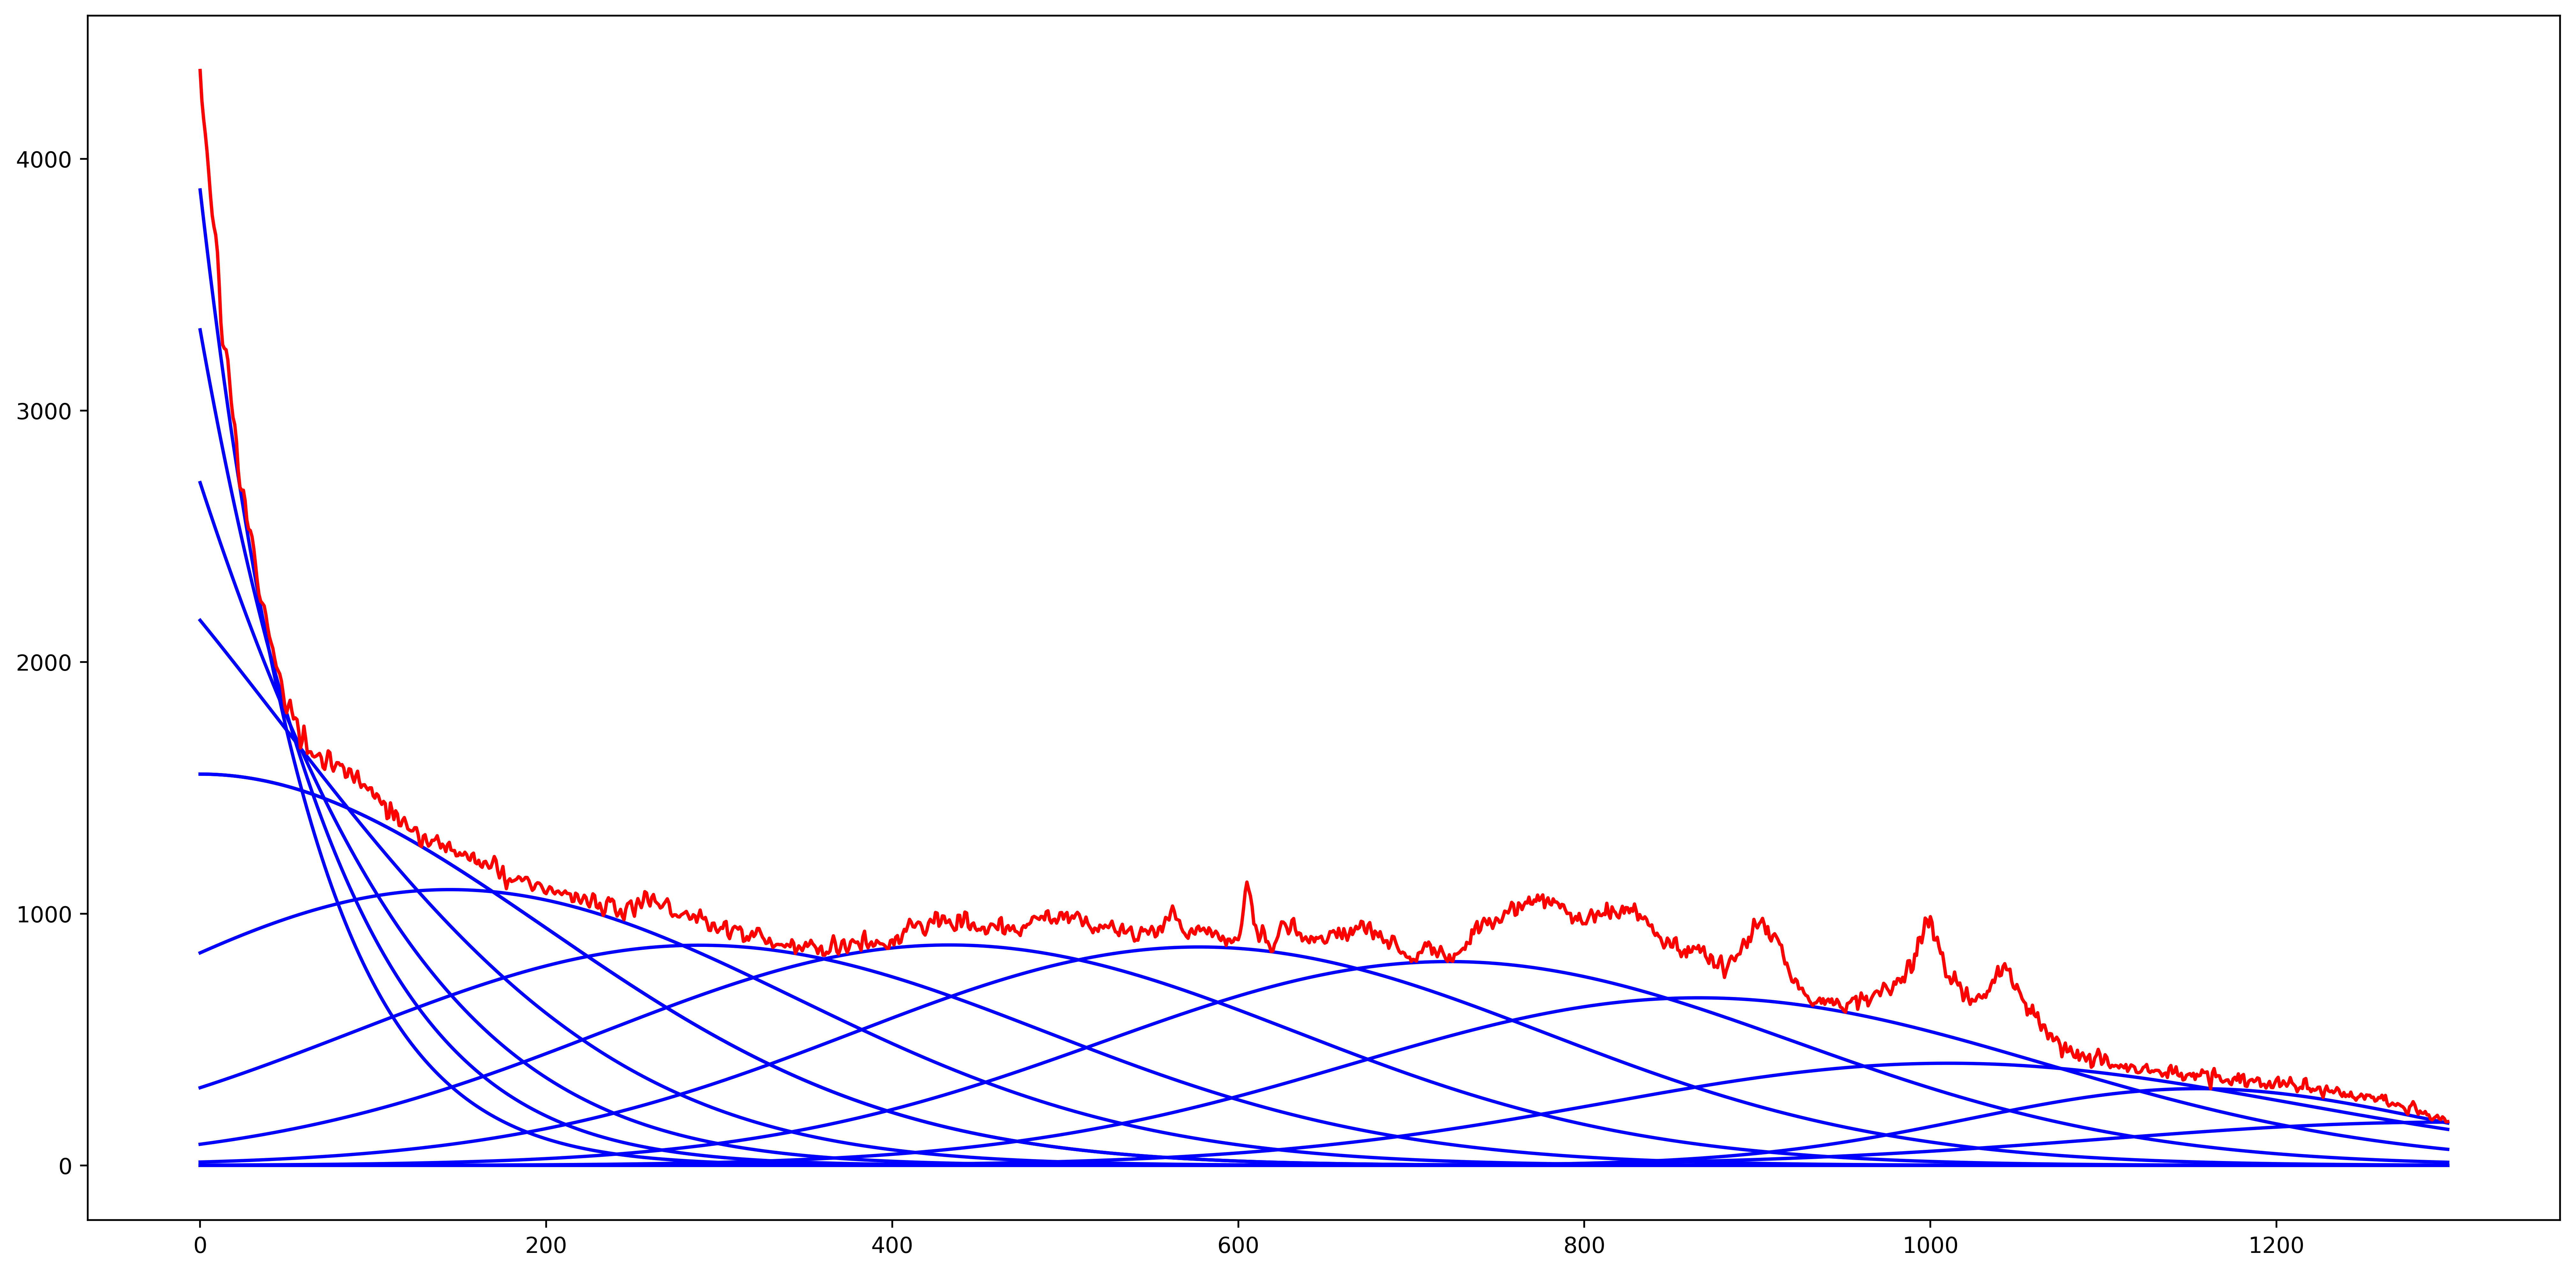

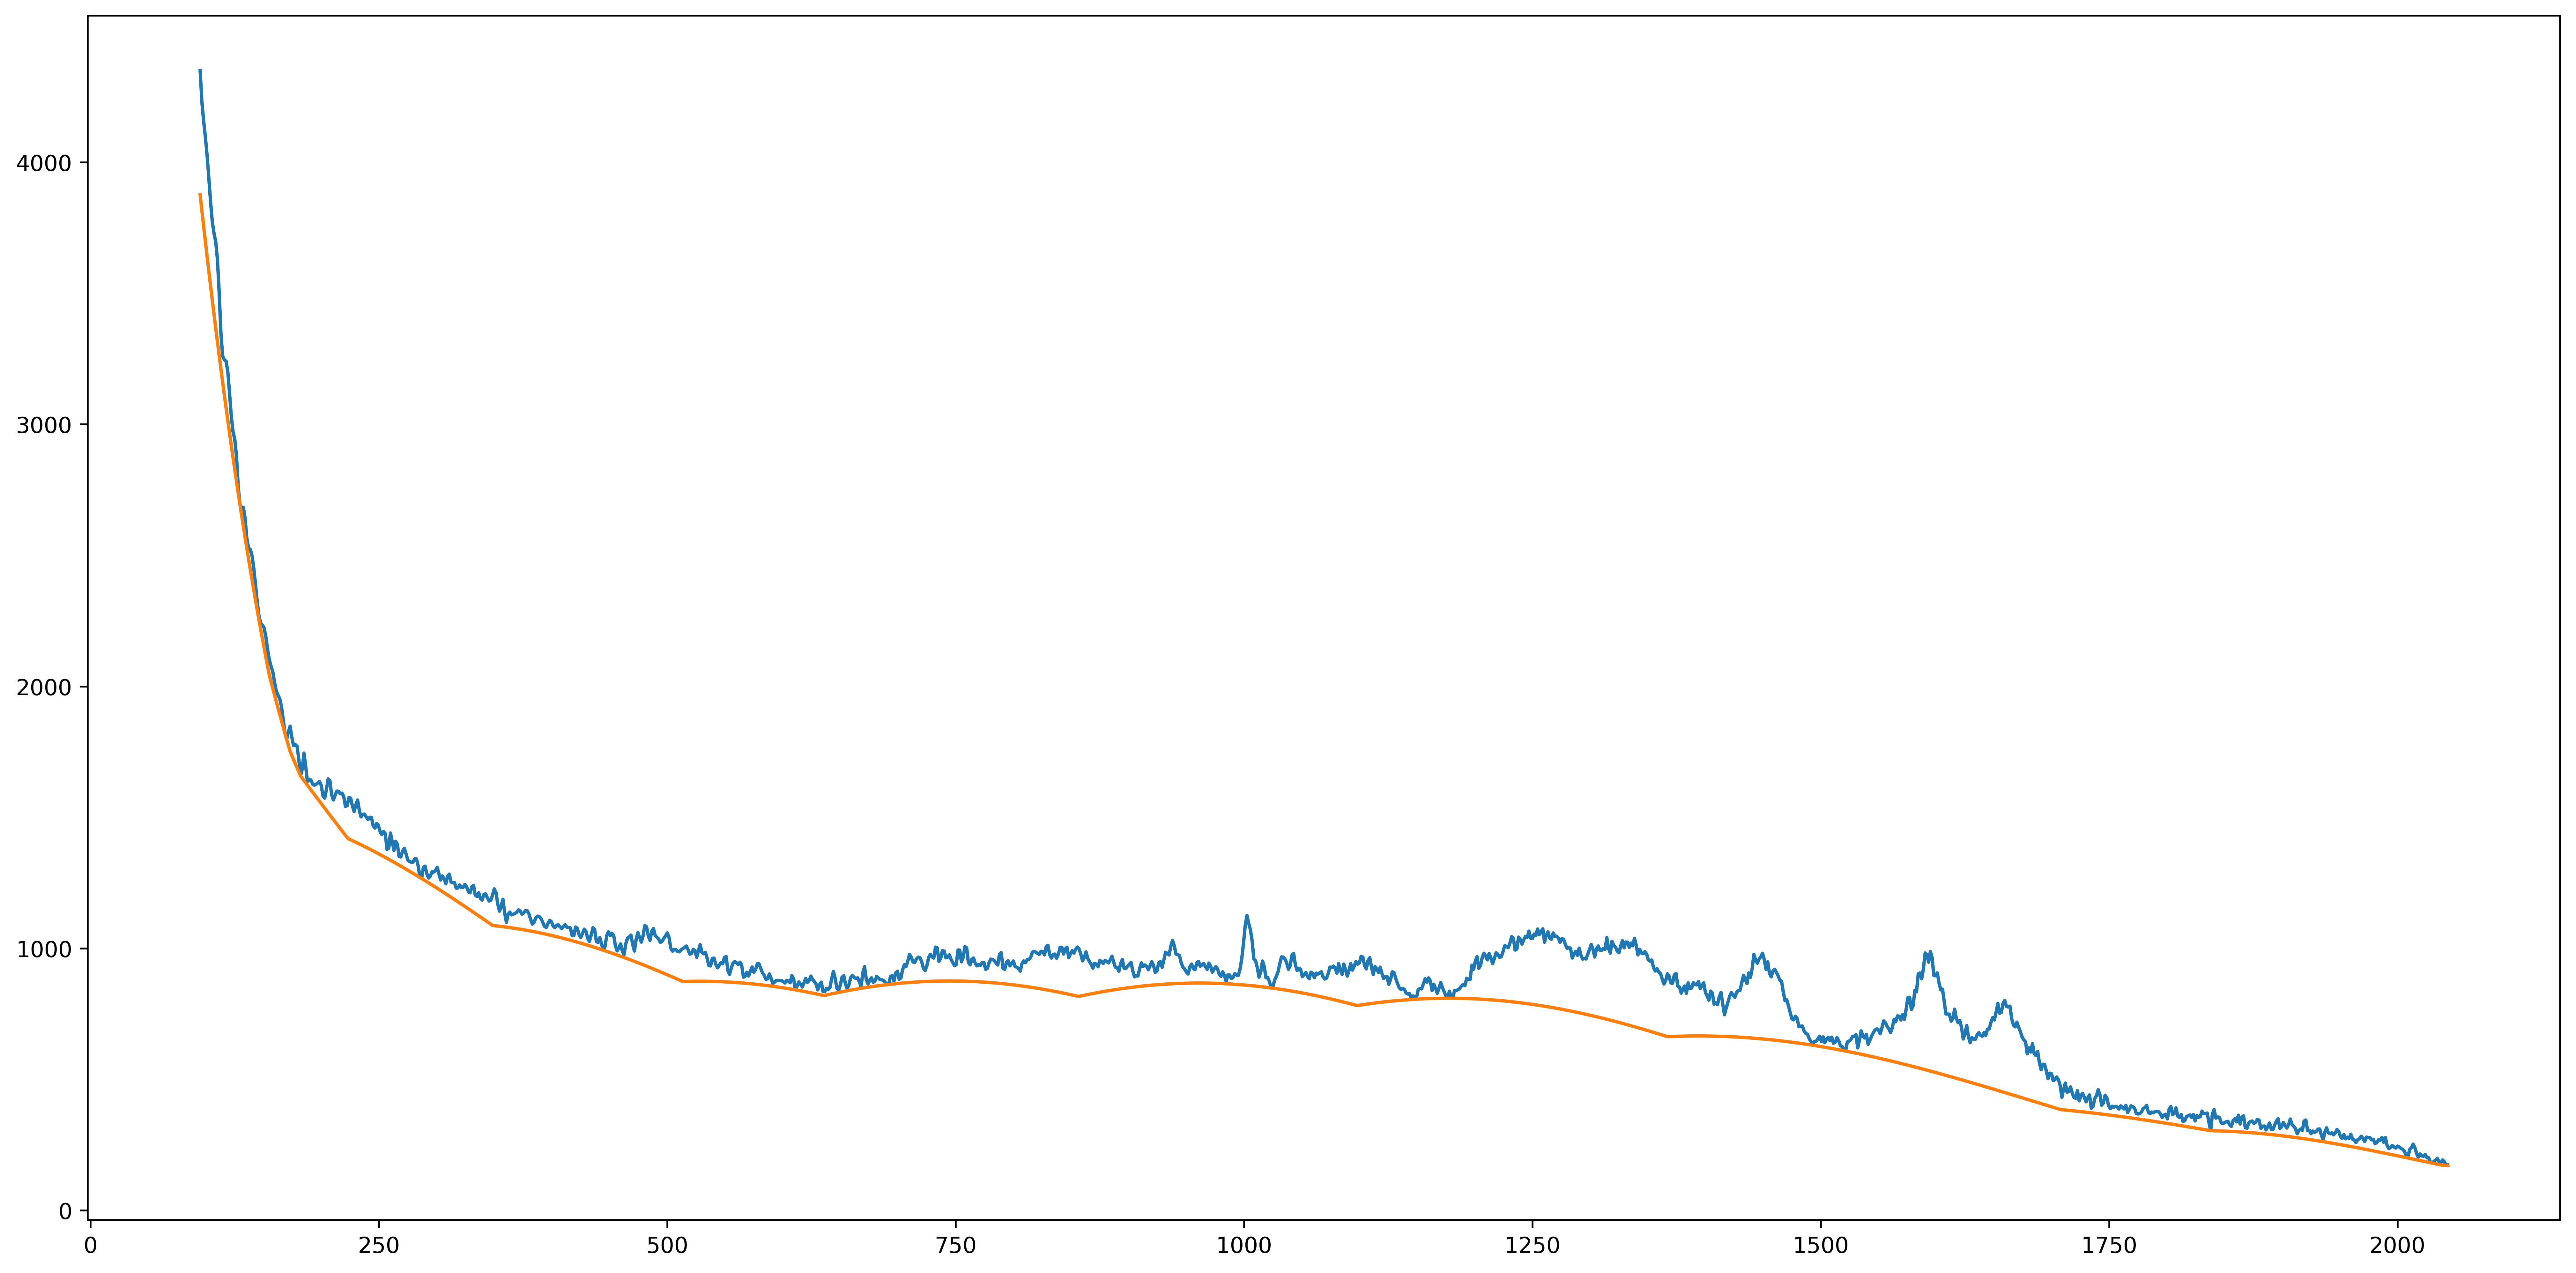

(-836.1111111111111, 279.07679703451214, 397) 28.82742363273679
(-603.3333333333335, 201.48904308481283, 745) 32.12611420624002
(-370.55555555555566, 150.0, 258) 34.63585294852686


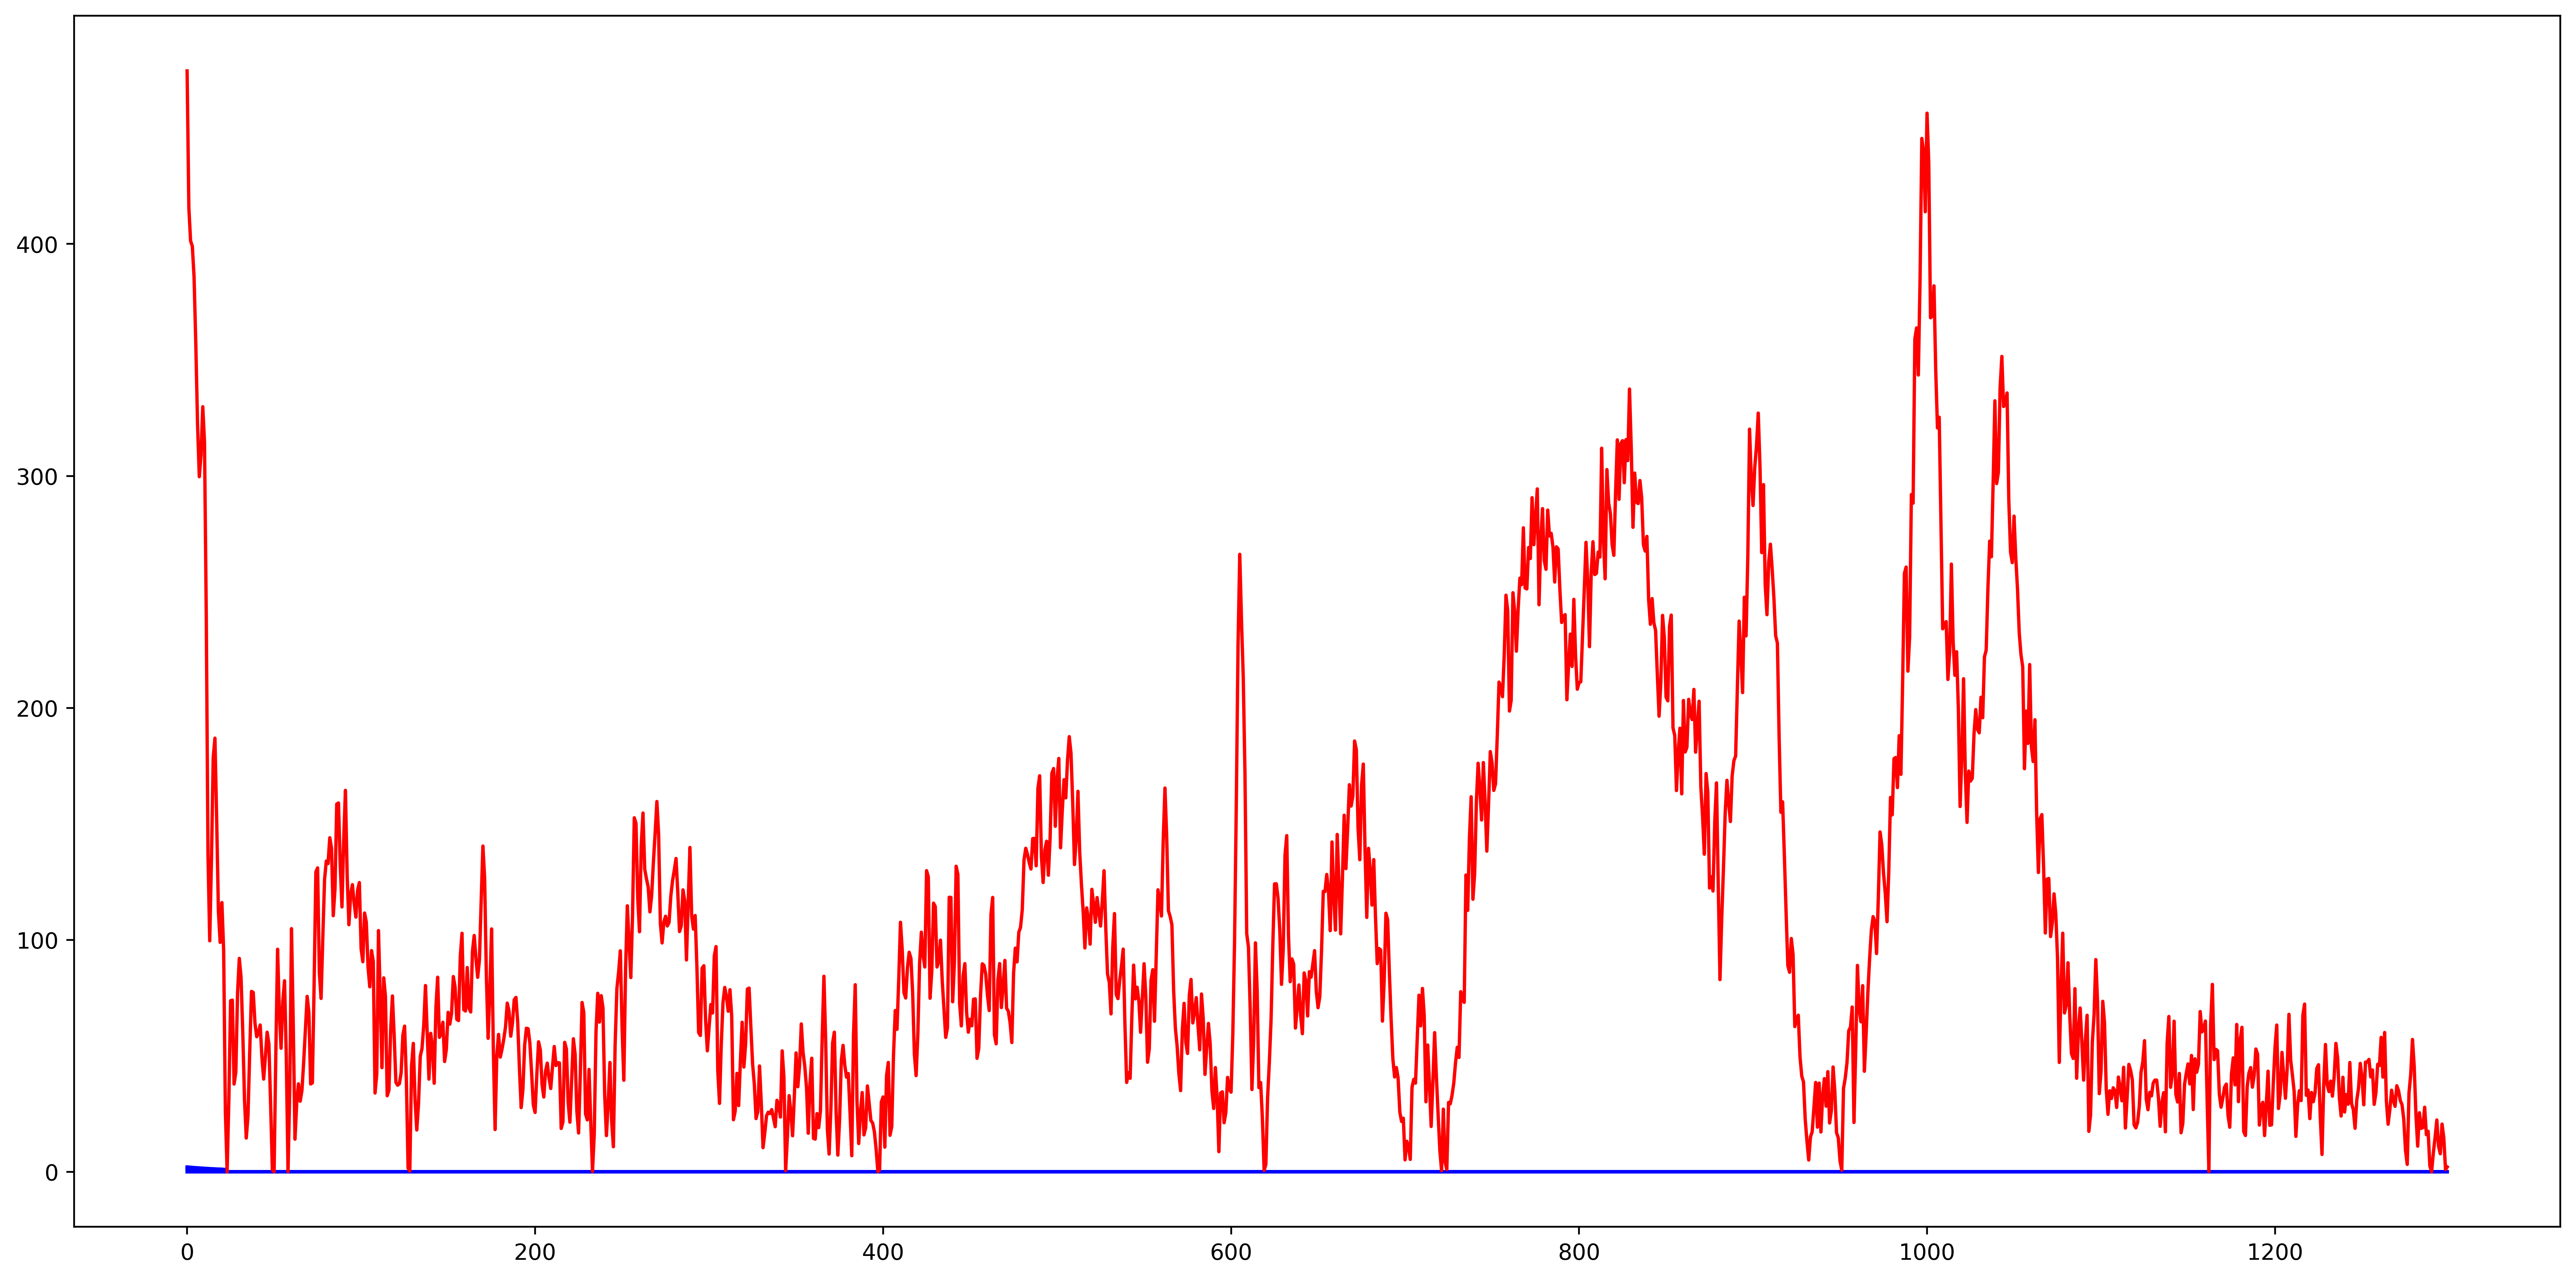

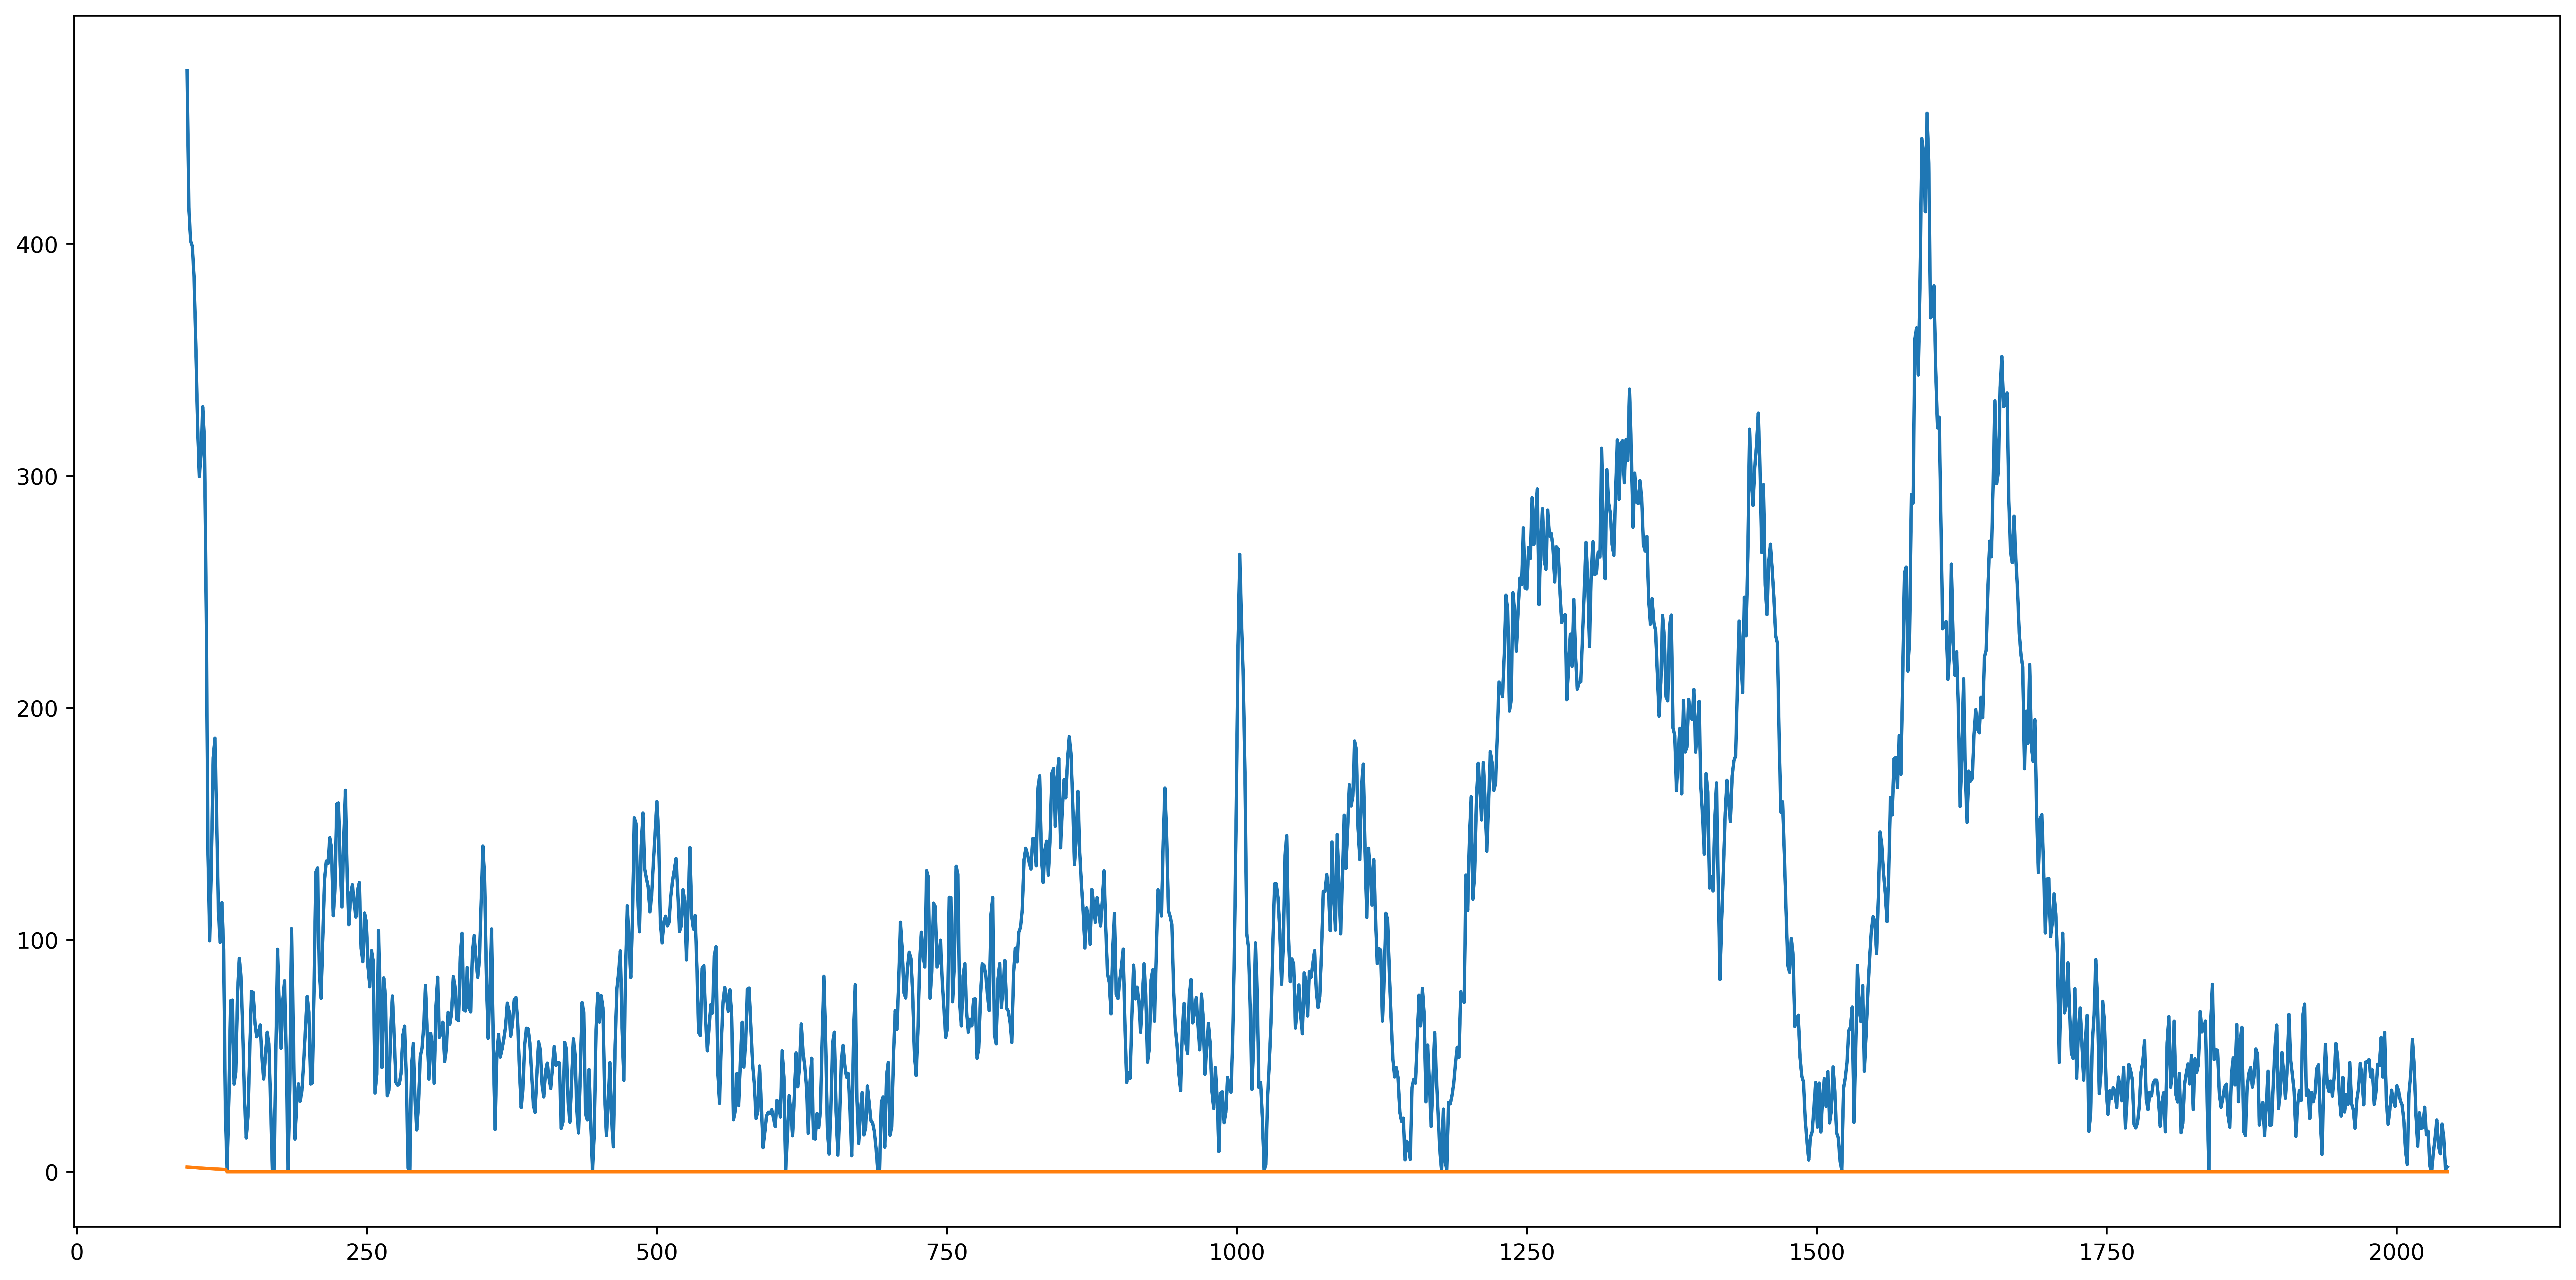

(-836.1111111111111, 279.07679703451214, 397) 28.82742363273679
(-603.3333333333335, 201.48904308481283, 745) 32.12611420624002
(-370.55555555555566, 150.0, 258) 34.63585294852686


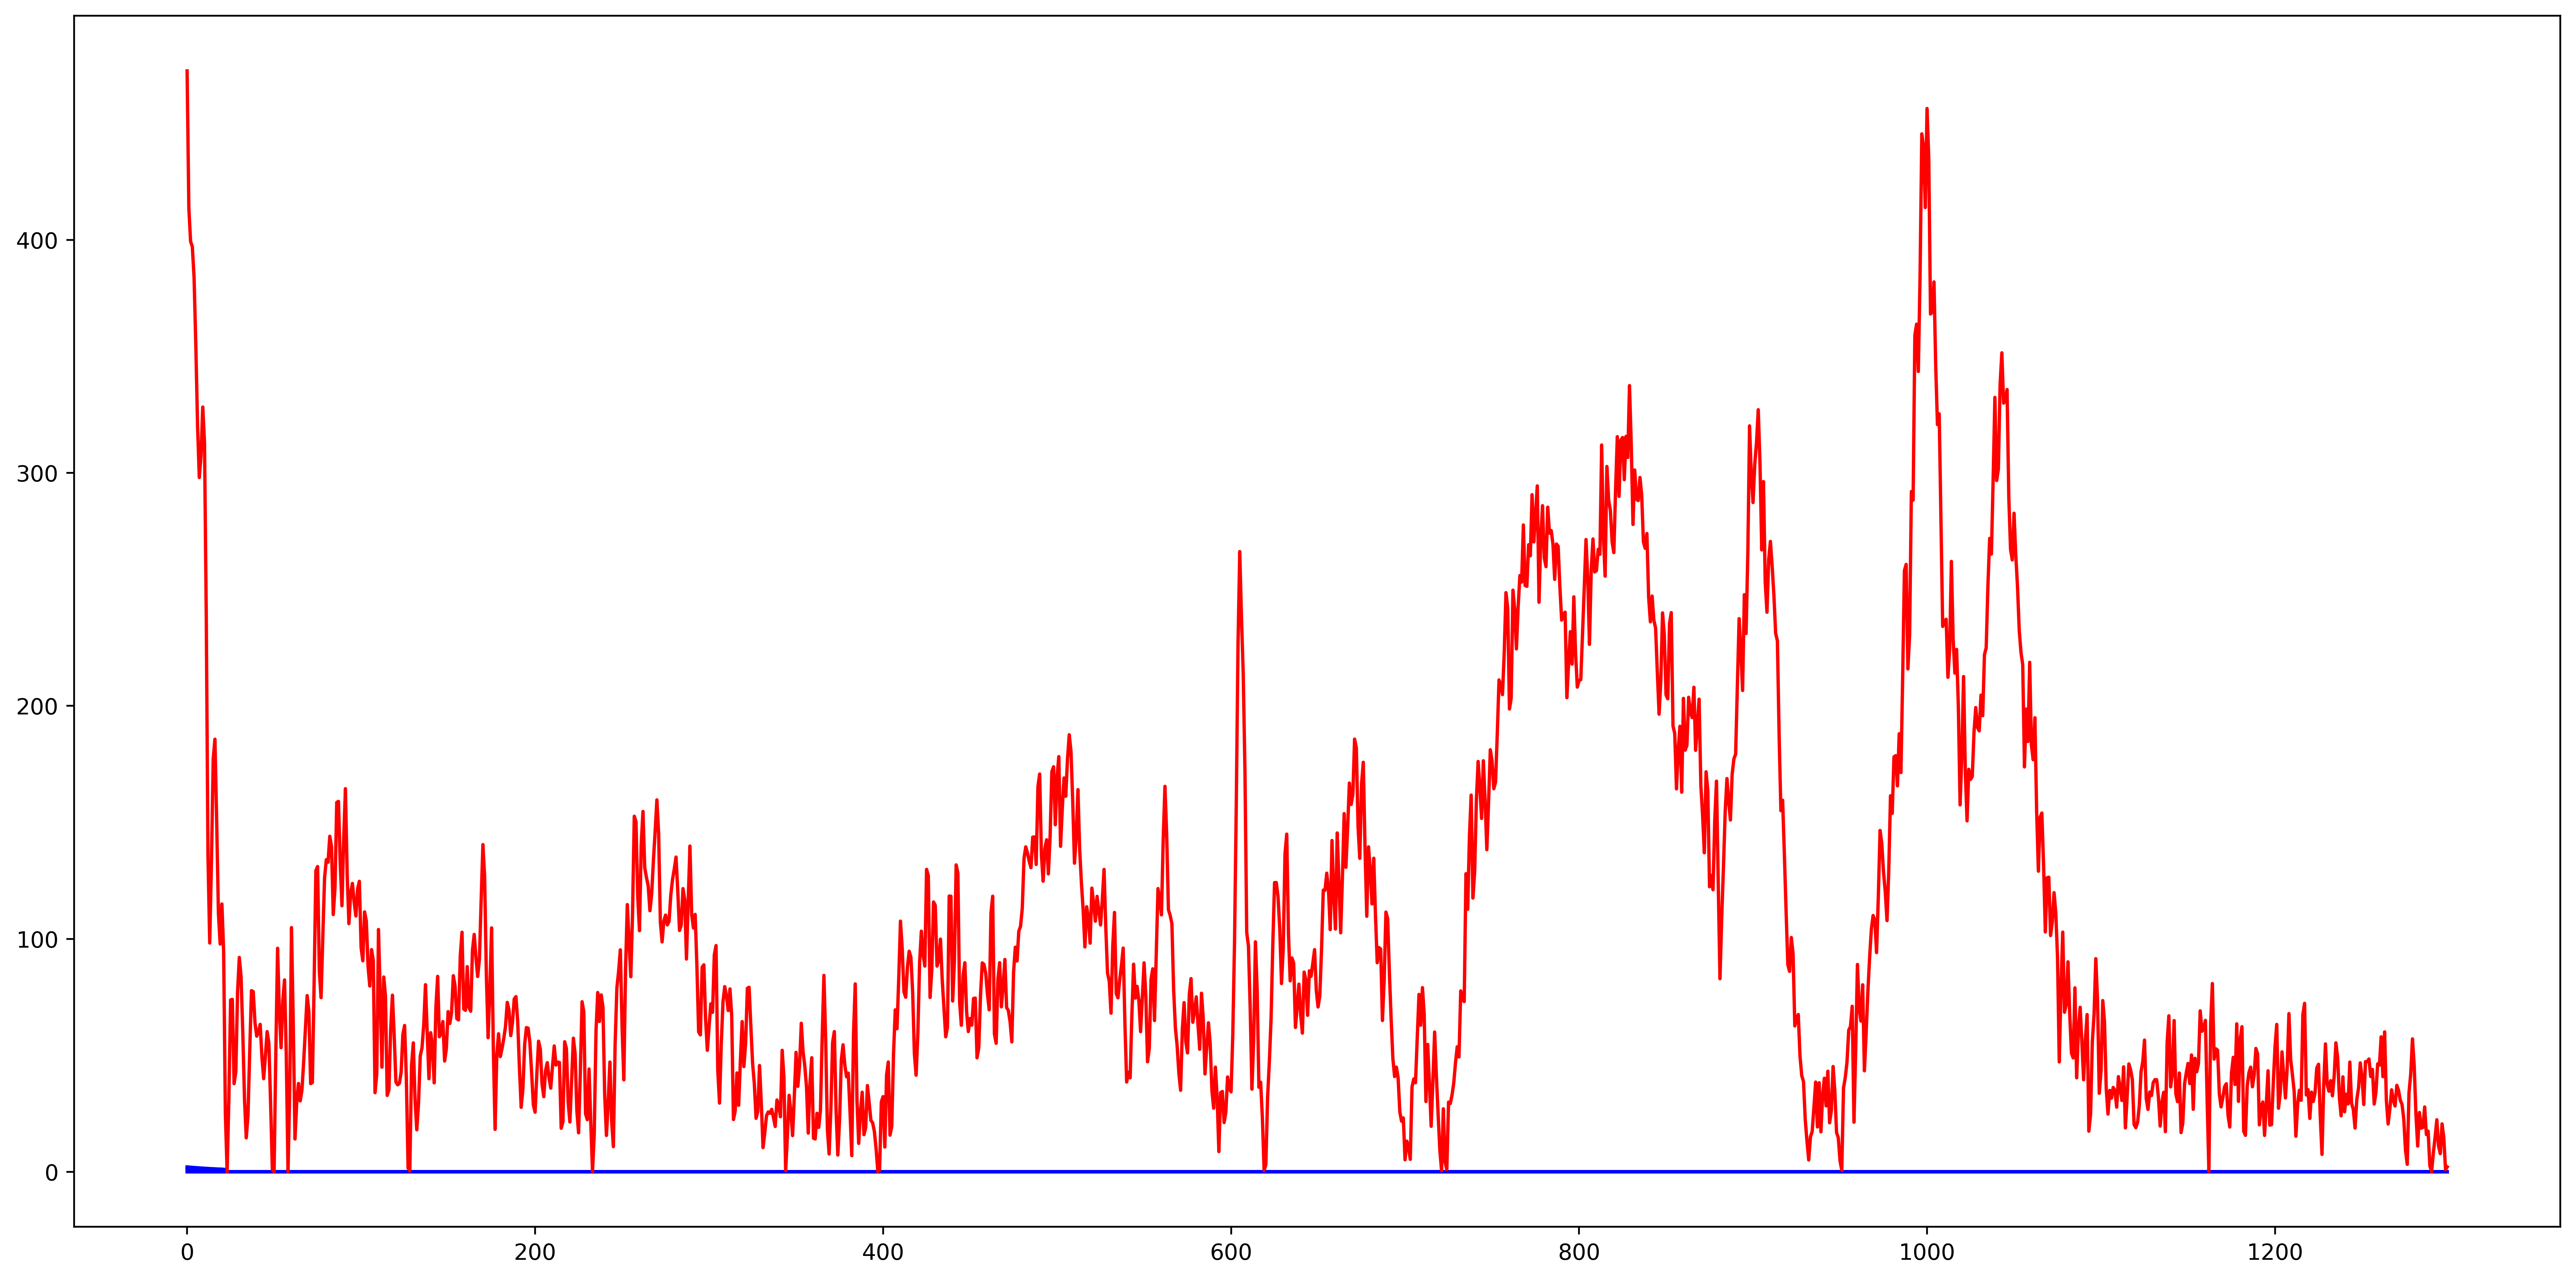

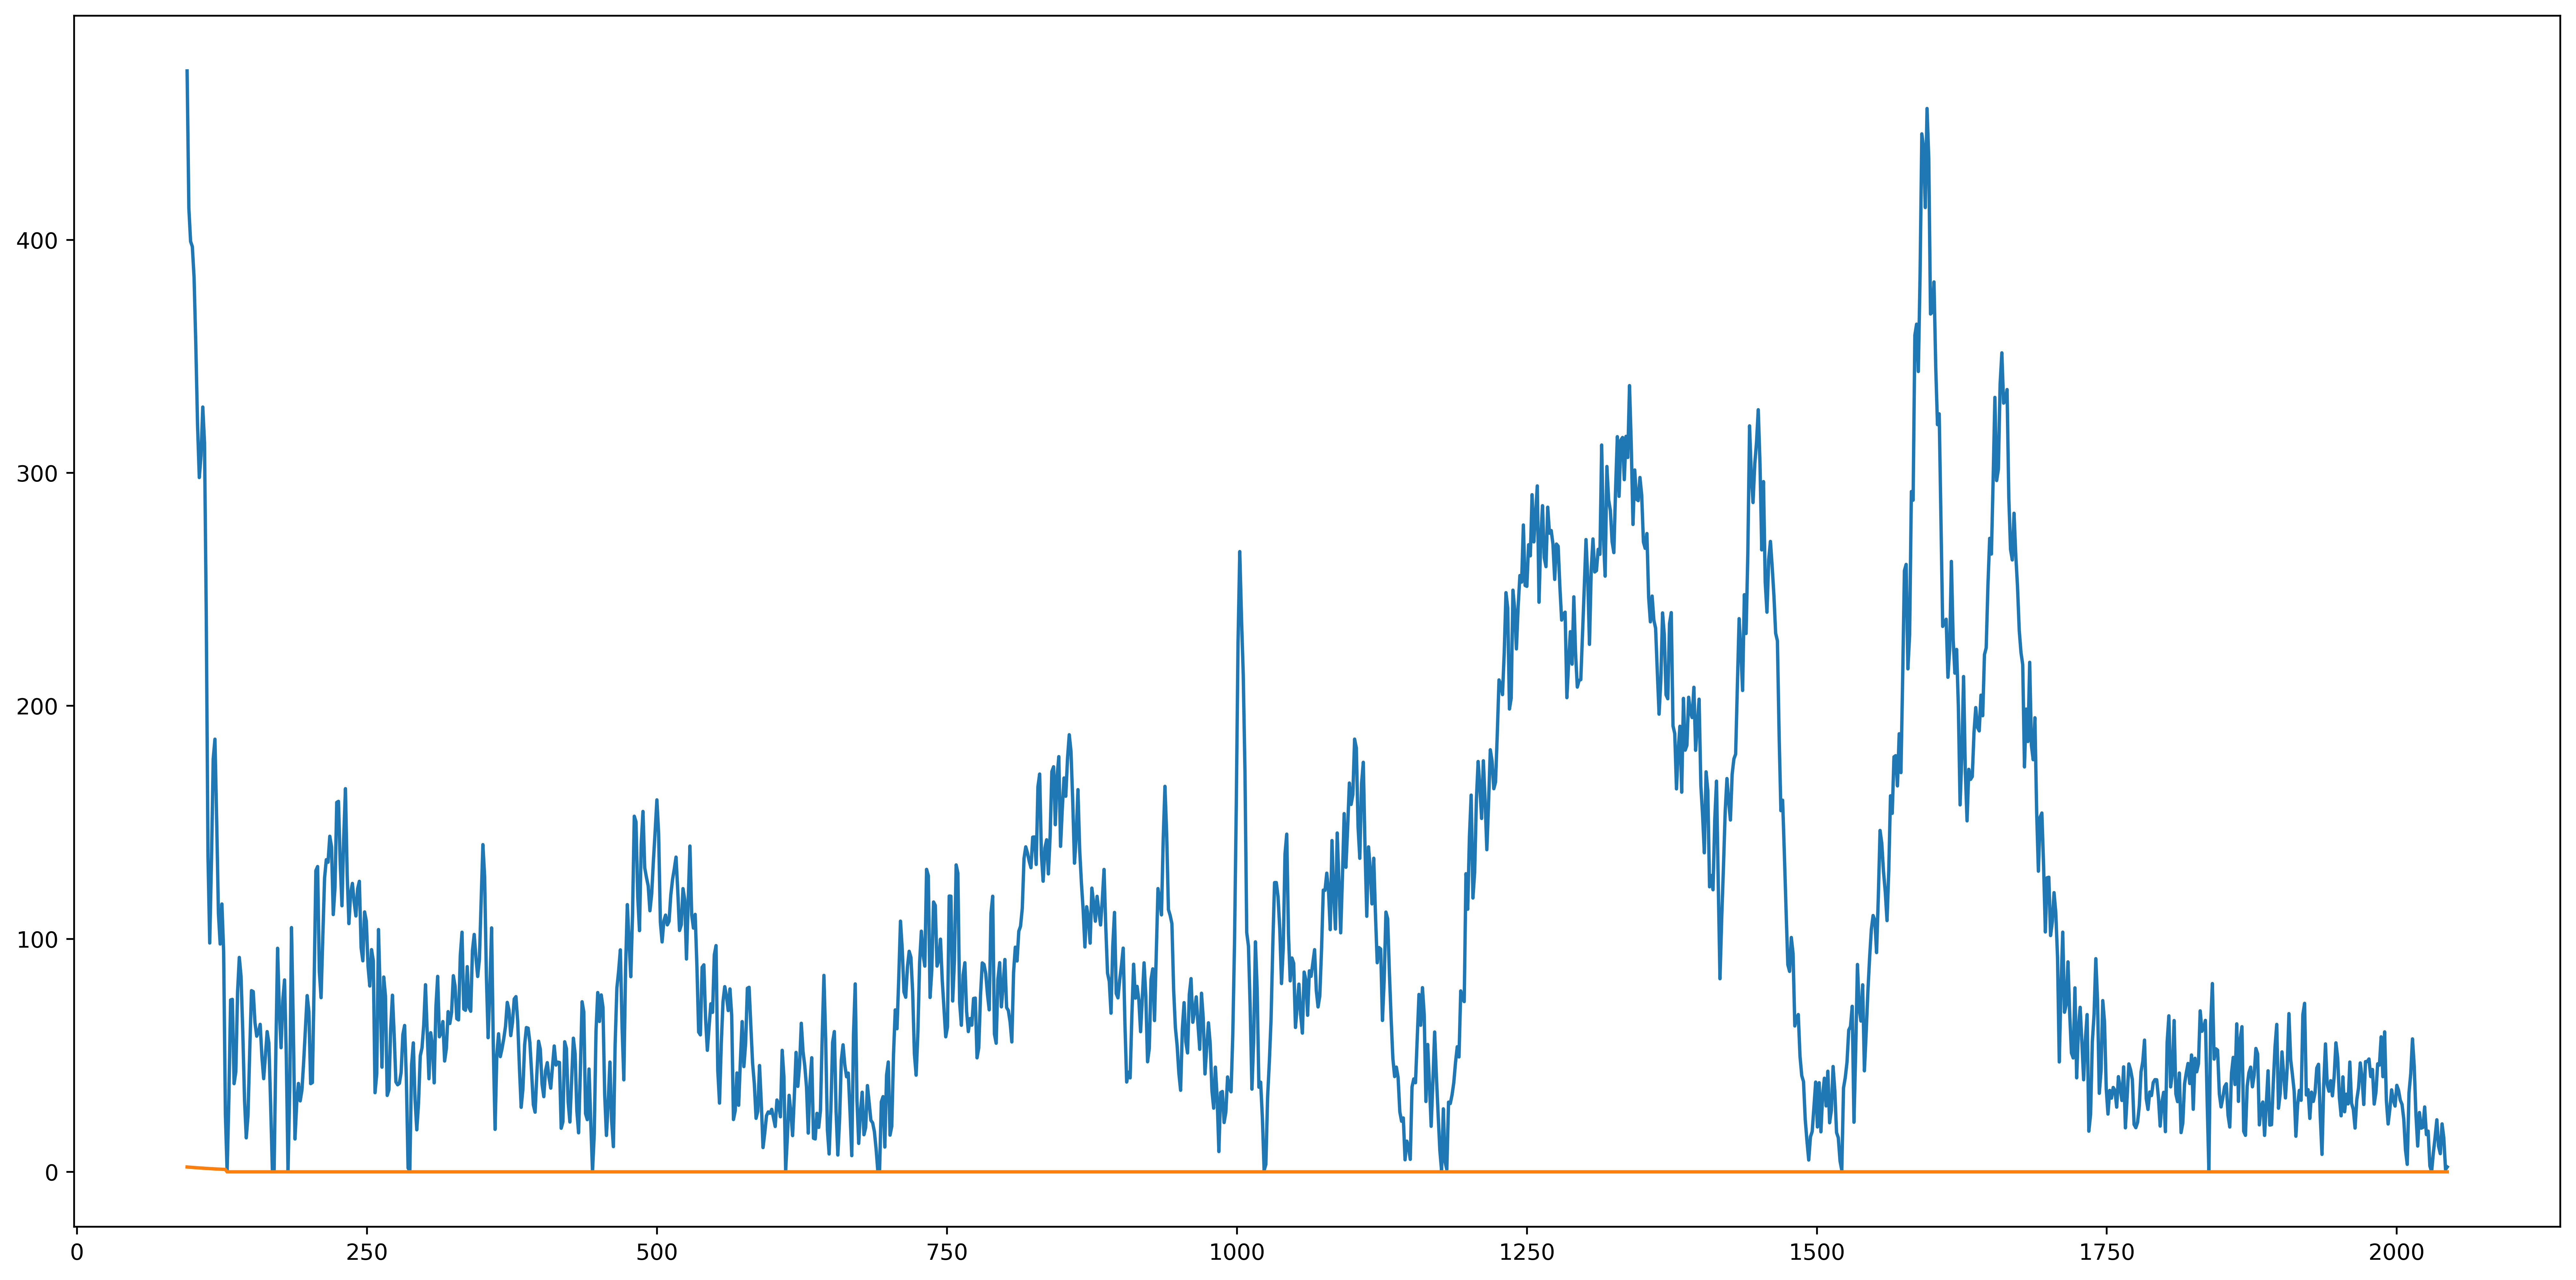

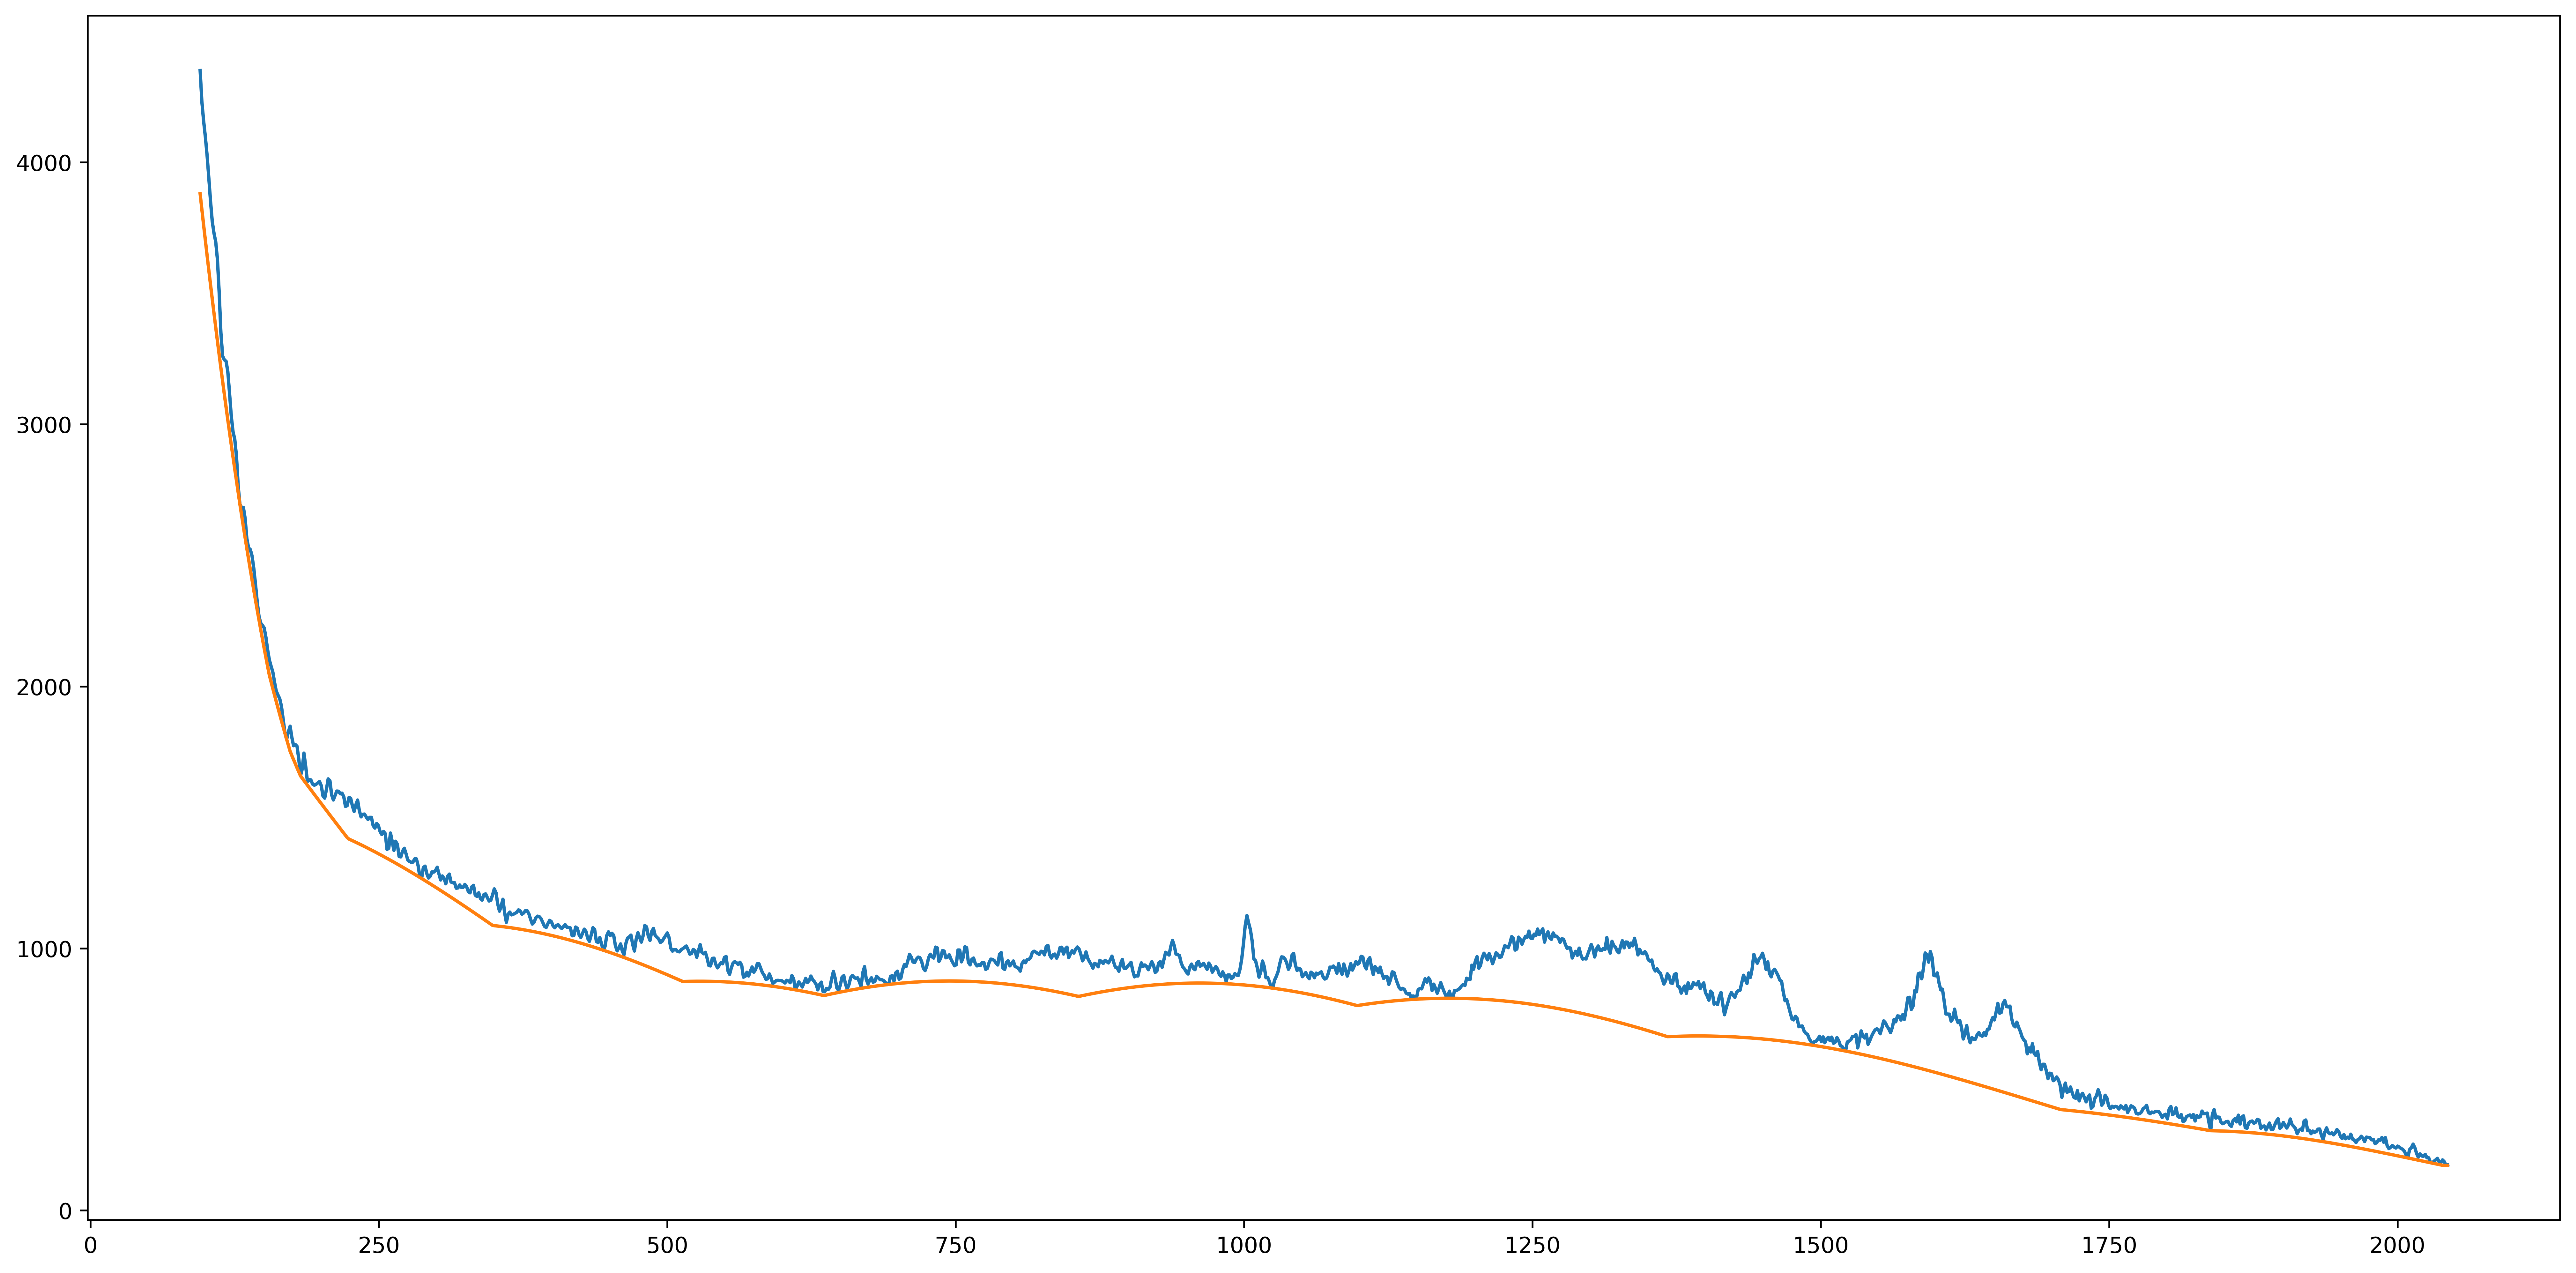

pixel: 85


TypeError: cannot unpack non-iterable NoneType object

In [20]:
import timeit
from os import path

# file_location2 = f"{'/'.join(file_location.split('/')[:-2])}/approximated/"
# os.makedirs(file_location2, exist_ok=True)

shape = data[0][0].shape

for j, (f, img) in enumerate(zip(filenames, data)):   
    start = timeit.default_timer()
#     if path.exists(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman.npy'):
#         print(f'file already exist {file_location2}{f.split("/")[-1].split(".")[0]}_raman')
#         continue

#     if j < 7:
#         continue
    
    raman, photo = split_signal(img)

    stop = timeit.default_timer()
    print('Time: ', stop - start)  

#     np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_raman', raman.reshape(shape))
#     np.save(f'{file_location2}{f.split("/")[-1].split(".")[0]}_photoluminescence', photo.reshape(shape))
#     print(f"image: {f} is done.")